ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19])])


/Users/ethanelliotrajkumar/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


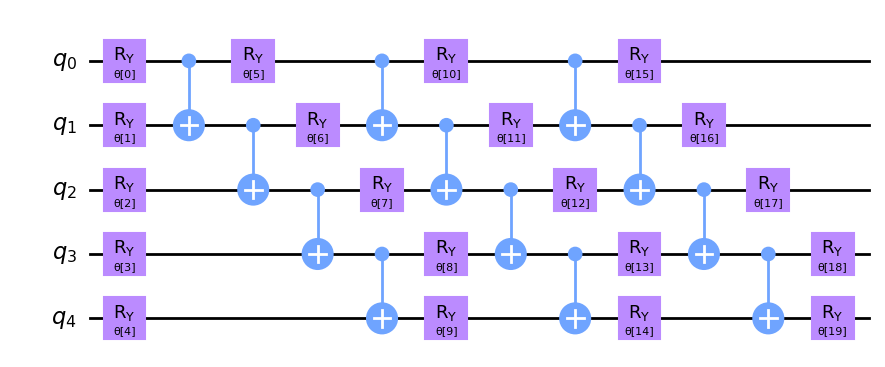

In [1]:

import sys
# Add the custom library directory to Python's search path for modules.
sys.path.append('/Users/ethanelliotrajkumar/Documents/DVR-VQE2.0/lib')
# Import modules and functions from the custom library.
from greedy_circs import *  # Assuming functions for circuit optimization
import numpy as np  # Importing NumPy for numerical computations
from dvr1d import *  # For 1D Discrete Variable Representation operations
from utils import *  # Utility functions that might be widely used
from vqe import DVR_VQE  # Importing the class for DVR using VQE
from pot_gen import get_pot_cr2  # Function to generate potential for CR2
from qiskit.circuit.library import TwoLocal  # For ansatz
from qiskit.quantum_info import SparsePauliOp  # For Pauli Decomposition

# FUNCTIONS
def gen_ansatz_op(mol_params, spin, params16):
        mol_params = mol_params.copy()  # create a copy to avoid changing the original mol_params
        mol_params['name'] += f'_{spin}'
        dvr_options = {
            'type': '1d',
            'box_lims': (params16[0], params16[1]),
            'dx': (params16[1] - params16[0]) / 16,
            'count': 16
        }

        # obtain the potential for a CR2 at certain spin
        pot, lims = get_pot_cr2(spin)

        # perform a dvr vqe to obtain the hamiltonian
        dvr_vqe = DVR_VQE(mol_params, pot)
        h_dvr = dvr_vqe.get_h_dvr(dvr_options, J=0) * hartree

        # Perform a Pauli Decomposition to get the Hamiltonian and get a composition.
        h_dvr_p0 = SparsePauliOp.from_operator(h_dvr)
        print(h_dvr_p0.coeffs)

        num_qubits = int(np.log2(h_dvr.shape[0]))
        a = TwoLocal(num_qubits, rotation_blocks=['ry'], entanglement_blocks=['cx'], entanglement='linear', reps=3).decompose()
        
        return h_dvr, h_dvr_p0, a
    
a = TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks=['cx'], entanglement='linear', reps=3).decompose()
a.parameters
print(a.parameters)
a.draw(output='mpl')

In [21]:
from qiskit_algorithms.minimum_eigensolvers import VQE

def Run_VQE(a, optimizers, params, estimator, operator):
        """ This is the function that runs the VQE."""
        repeat = 3
        params = None
        # params = np.array([float(i) for i in result.optimal_parameters.values()])
        converge_cnts1 = np.empty([len(optimizers)], dtype=object)
        converge_vals1 = np.empty([len(optimizers)], dtype=object)
        converge_params = np.empty([len(a.parameters)], dtype=object)
        for i, optimizer in enumerate(optimizers):
            print('Optimizer: {}        '.format(type(optimizer).__name__))
            # algorithm_globals.random_seed = 42

            def store_intermediate_result(eval_count, parameters, mean, std):
                counts.append(eval_count)
                values.append(mean)
                print(f'\r{eval_count}, {mean}', end='')
            best_res1 = None
            
            for j in range(repeat):
                counts = []
                values = []
                parameters = None
                vqe = VQE(estimator=estimator, ansatz=a, optimizer=optimizer, initial_point=parameters, callback=store_intermediate_result)
                results = vqe.compute_minimum_eigenvalue(operator=operator)
                print(parameters)
                if (best_res1 is None) or (values[-1] <= best_res1):
                    best_res1 = values[-1]
                    converge_cnts1[i] = np.asarray(counts)
                    converge_vals1[i] = np.asarray(values)
                    converge_params[i] = np.asarray(parameters) 
        print('\nOptimization complete ') 
        return converge_cnts1, converge_vals1, converge_params, results



In [22]:
# PARAMETERS AND FUNCTION CALLS
from qiskit_algorithms.optimizers import BOBYQA, IMFIL,UMDA, POWELL, NFT
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options
spin = 13
params16 = [5.2, 9]
optimizers = [UMDA(maxiter=100)]
mol_params = cr2_params
from qiskit_ibm_runtime import QiskitRuntimeService, Batch 

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='pinq-quebec-hub/qai-quantum-algo/default',
    token='50e4f60f02cd247a763d93cbeb949668b4383e6df68ba8a7b4c97b35be7d9cf41f83566cb249b7619d46f081d8349d911392a9d12def4088966310b9168a7f10'
)

backend = service.get_backend('ibm_quebec')
options = Options(optimization_level=2, resilience_level=2)
jobs =[]
with Session(backend=backend, service=service) as session:
    estimator = Estimator(backend=backend, options=options, session=session)
    h_dvr, h_dvr_p0, a = gen_ansatz_op(mol_params, spin, params16)
    job = estimator.run(Run_VQE(a, optimizers, None, estimator, h_dvr_p0))
    session = [job]
    session.close() 


[ 2.8  3.2  3.6  4.   4.4  4.8  5.2  5.6  6.   6.4  6.8  7.2  7.6  8.
  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  22.  24.
 28.  32.  36.  40. ]
[-2.31228177e+02+0.j -7.83306924e+01+0.j  1.69700000e+01+0.j
  1.95645497e+01+0.j -4.35063661e+01+0.j -8.79587714e-04+0.j
 -3.48244246e+01+0.j  2.87361414e+01+0.j  1.76290430e-03+0.j
  1.95782543e+01+0.j  4.87327822e+00+0.j -5.89626923e+00+0.j
 -8.58655634e-04+0.j  1.08588196e+01+0.j -2.29247952e+01+0.j
 -8.51776159e-04+0.j  1.70284329e+01+0.j -1.71043179e-03+0.j
  1.70698297e-03+0.j -9.33569045e-05+0.j -2.78595397e+00+0.j
 -1.77959917e+01+0.j  8.70610614e+00+0.j -2.05819456e+01+0.j
  2.45987504e+01+0.j  3.46988727e-03+0.j  3.13850824e+01+0.j
 -3.44867514e-03+0.j  3.44162992e-03+0.j -1.89312386e-04+0.j
  5.89047993e+01+0.j  3.79958835e-04+0.j  1.72235963e+01+0.j
  1.20137213e+00+0.j -1.26030944e+00+0.j -7.90441433e-04+0.j
  1.45719563e+00+0.j -1.56422432e+00+0.j -7.84784303e-04+0.j
  3.03833495e-01+0.j -1.57522574e-03+0.j  1.5

/Users/ethanelliotrajkumar/anaconda3/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:915: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)


135, -283.95283403516197

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import u3 
import numpy as np
from qiskit.circuit.library import TwoLocal, CXGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
# Create a quantum circuit with 4 qubits
qc = QuantumCircuit(4)

# Define the parameters
X = [Parameter(f'X[{i}]') for i in range(9)]

# Add gates according to the provided image
qc.u(np.pi, -np.pi, 0, 0)

circuit = transpile(qc, basis_gates=['ecr', 'rz', 'sx', 'x'])

print(circuit)

global phase: π
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
          
q_3: ─────
          
